A grandes rasgos, los mecanismos de votación en ensambles diferencia en una primera
etapa si el vector objetivo es continuo o discreto. Posteriormente, se diferencia por el grado
de ponderación a cada modelo dentro del ensamble.

#### Métodos de combinación para vectores objetivos continuos
Si tenemos un modelo 𝑡 ∈ 𝑇 donde 𝑇 es un conjunto de modelos t entrega una función
candidata ℎ𝑖(𝑥) ∈ 𝑅

El objetivo es combinar cada función candidata en el ensamble 𝑇 para generar una
predicción final. Existen dos grandes variantes.

##### Promedio simple
Como lo señala su nombre, el ensamble promedia cada una de las predicciones realizadas
por el modelo.

$$ \mathcal{H}(x) \dfrac{1}{\mathcal{T}} \sum^{\mathcal{T}}_{i=1} h_t(x) $$

Supongamos que deseamos aprender una función 𝑓(𝑥) donde 𝑥 sigue una distribución
arbitraria 𝑝(𝑥).

Resulta que las funciones candidatas h se pueden escribir de la siguiente manera:

$$ h_i(x) = f(x) + \epsilon_i(x), \forall_t \thickapprox T $$

Este hecho permite desagregar la variabilidad de cada función candidata entre una "valor
verdadero" y un término de error específico al ensamble. Mediante esta desagregación del
error se puede analizar el error promedio del ensamble y observar si es menor a la
esperanza del error (para más detalles sobre este supuesto, referirse a Zhou, 2012, pp. 69).

Dada la simplicidad y efectividad, es uno de los métodos más utilizados. Uno de los
problemas es que se realiza el supuesto que los errores de cada función candidata no están
correlacionados entre sí, situación extremadamente rara cuando implementamos
ensambles.

#### Promedio ponderado

Una manera de calibrar las predicciones realizadas por un ensamble heterogéneo es
mediante la inclusión de ponderadores de la siguiente manera

$$ \mathcal{H}(X) = \dfrac{1}{\mathcal{T}}\sum^{\mathcal{T}}_{i=1}\omega_t h_t(X) $$

Donde $𝑤_i$ es el ponderador de la función candidata de un modelo candidato

Todo ponderador es no negativo y la suma de éstos da 1.

### Ejemplo: Estimando el tiempo de ejecución de tareas en un HPC

Caveat: Por motivos expositivos, el objetivo del ejercicio es demostrar bajo qué situaciones un
ensamble puede empeorar la capacidad de generalización en los datos. Deben tener en
cuenta que la experiencia práctica es reducir la pérdida y mejorar la predicción.

Para ilustrar el funcionamiento del mecanismo de votación, analizaremos el tiempo de
ejecución de trabajos en un ambiente HPC (High Performance Computing). El objetivo es
generar un modelo predictivo que prediga correctamente aquellos trabajos que tendrán un
tiempo de ejecución substancialmente alto. De los 4331 registros existentes, se capturaron
siete atributos:

- Protocol: El tipo de la computación implementada en 𝑥i registro.
- Compounds: La cantidad de puntos de datos para cada trabajo.
- InputFields: La cantidad de características a estimar en cada trabajo.
- Iterations: El número máximo de iteraciones a ejecutar por trabajo.
- NumPending: La cantidad de trabajos en lista a ser ejecutados.
- Hour: Hora decimal para la hora de ejecución.
- Day: Día de la ejecución.
- Class: El vector objetivo que mide el tiempo de ejecución. Ésta contiene cuatro
  categorías: Very Fast (VF), Fast (F), Medium (M), Low (L).


In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lec10_graphs as afx

# Módulos de preprocesamiento
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
# Módulos de modelos
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
rep_seed = 11238

In [2]:
df = pd.read_csv('Datasets/hpcjobschedule.csv').drop(columns='Unnamed: 0')
df.sample(5, random_state = 15820)

,Protocol,Compounds,InputFields,Iterations,NumPending,Hour,Day,Class
1193,I,132,4498,20,0,10.433333,Wed,F
3780,O,1209,609,200,0,3.766667,Sat,L
26,E,155,116,20,0,10.433333,Fri,VF
983,H,38,94,100,0,10.383333,Thu,M
864,H,145,289,20,263,13.783333,Wed,F


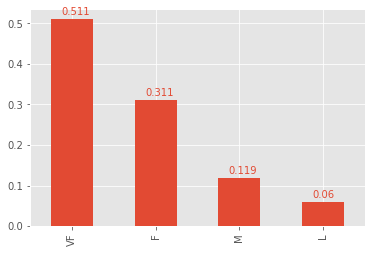

In [3]:
def annotated_barplot(var):
    tmp_values = var.value_counts('%')
    tmp_ax = tmp_values.plot(kind='bar')
    for index, p in enumerate(tmp_ax.patches):
        tmp_ax.annotate(tmp_values[index].round(3),xy=(p.get_x() + .125, 
                        p.get_height() + 0.01),color=p.get_facecolor())
annotated_barplot(df['Class'])

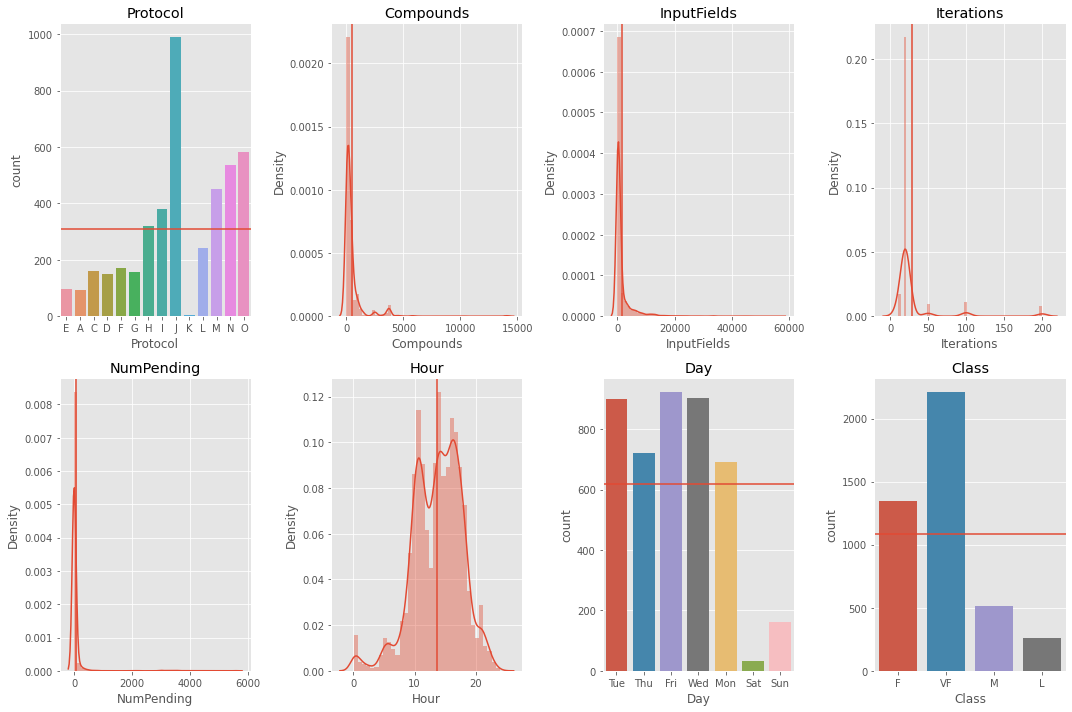

In [4]:
plt.figure(figsize = (15, 10))
# definimos el dimensionado de nuestra grilla
rows = 2; cols = len(df.columns) // rows
# definimos el tamaño de la figura
afx.plot_describe_variables(df, rows = rows, cols = cols)

### Implementación de sklearn.ensemble.VotingClassifier
Para entender la implementación de un mecanismo de votación, generaremos la siguiente
estrategia analítica:
1. Comencemos por incorporar los módulos clásicos de evaluación para tareas de
   clasificación, así como el módulo de separación de muestras.
2. Posteriormente incorporaremos una serie de modelos candidatos que participarán
   en el mecanismo de votación. Éstos son:
  - Naïve Bayes: sklearn.naive_bayes.BernoulliNB.
  - Análisis Discriminante Lineal:
    - sklearn.discriminant_analysis.LinearDiscriminantAnalysis
    - Regresión logística: sklearn.linear_model.LogisticRegression.
    - Árboles de clasificación: sklearn.tree.DecisionTreeClassifier.
    - Clasificador con soporte vectorial con un kernel: rbf.sklearn.svm.SVC.
    - Kmeans con dos clusters: sklearn.cluster.KMeans.
    - Modelo de Mezcla Gaussiana con dos clusters:
      - sklearn.mixture.GaussianMixture.
3. Finalmente incorporaremos el módulo sklearn.ensemble.VotingClassifier.

Nuestro objetivo es generar un sistema predictivo para aquellos casos donde la demora es
substancialmente menor. Para ello recodificaremos y aislaremos la variable que identifique
aquellas observaciones clasificadas como "Very Fast". De manera adicional,
implementaremos los pasos de división entre muestras de evaluación, holdout,
entrenamiento y validación.

Un aspecto a considerar es que en este caso el vector objetivo presenta clases
desbalanceadas, por lo que el desempeño del modelo debería ser similar para predecir
ambas clases.


In [5]:
# recodificamos nuestro vector objetivo
df['very_fast'] = np.where(df['Class'] == 'VF', 1, 0)
# generamos un conjunto de variables binarias para Day y Protocol.
df = pd.concat([df,pd.get_dummies(df['Day'], drop_first = True)], axis = 1)
df = pd.concat([df, pd.get_dummies(df['Protocol'], drop_first = True)], axis = 1)
# Eliminamos las variables originales
df = df.drop(columns = ['Protocol', 'Class', 'Day'])

Retomando el gráfico descriptivo de los datos, un problema existente con los atributos
Compounds, InputFields, Iterations, NumPending era la concentración en valores bajos.
Para corregir por este sesgo tomaremos el logaritmo de cada variable y le sumaremos 0.01
para evitar el problema 𝑙𝑜𝑔(0).

In [6]:
log_vars = ['Compounds', 'InputFields', 'Iterations', 'NumPending']
for i in log_vars:
    df[i] = df[i].apply(lambda x: np.log(x +0.001))


Si revisamos la corrección de las variables, observamos que los atributos Compounds e
InputFields cambiaron drásticamente el comportamiento, asemejándose a una
distribución más normal. Lamentablemente eso no se replica para:

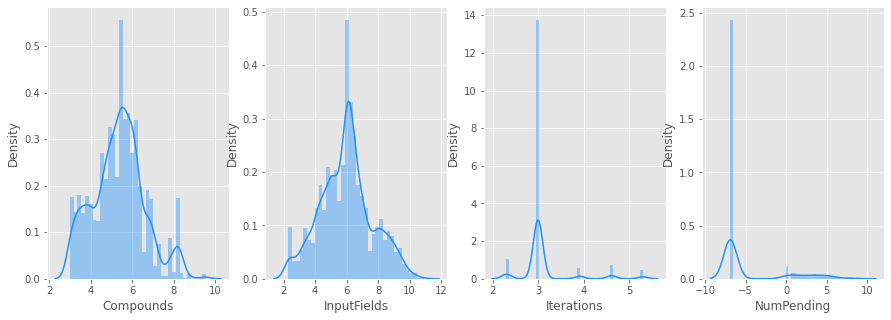

In [7]:
plt.figure(figsize = (15, 5))
for index, value in enumerate(log_vars):
    plt.subplot(1, 4, index + 1)
    sns.distplot(df[value], color = 'dodgerblue')


In [8]:
# preservamos en una nueva variable nuestro vector objetivo
y = df.pop('very_fast')
# Generamos la separación entre muestra de evaluación y holdout
X_eval, X_holdout, y_eval, y_holdout = train_test_split(df, y, test_size = .33, random_state = rep_seed)
# Separamos la muestra de entrenamiento entre entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X_eval, y_eval, test_size=.33, random_state = rep_seed)

In [9]:
print(f'''
Registros holdout: {X_holdout.shape[0]} / Atributos holdout: {X_holdout.shape[1]}
Registros training: {X_train.shape[0]} / Atributos training: {X_train.shape[1]}
Registros testing: {X_test.shape[0]} / Atributos holdout: {X_test.shape[1]}''')


Registros holdout: 1430 / Atributos holdout: 24
Registros training: 1943 / Atributos training: 24
Registros testing: 958 / Atributos holdout: 24


Montando el ensamble de clasificadores heterogéneos
Para implementar la lista de estimadores, sklearn.ensemble.VotingClassifier necesita
de una lista de tuplas, donde cada tupla debe seguir la siguiente nomenclatura: ('Etiqueta
del Estimador', MóduloDelModelo). Para este ejemplo, definiremos la siguiente lista:

In [15]:
# definimos el comité de clasificadores en una lista de tuplas
# para el caso de kmeans y GMM es necesario definir la cantidad de clusters a inferir 
# tuve que quitar estos hiper parametros para que corra , n_jobs=None, precompute_distances='auto'
estimators = [('Linear Discriminant Analysis', LinearDiscriminantAnalysis()),
            ('Logistic Regression', LogisticRegression(random_state = rep_seed)),
            ('Decision Tree Classifier', DecisionTreeClassifier(random_state = rep_seed)),
            ('Support Vector Classifier', SVC(kernel = 'linear', random_state = rep_seed)),
            ('Kmeans', KMeans(n_clusters = 2, random_state = rep_seed)),
            ('Gaussian Mixture Model', GaussianMixture(n_components = 2,random_state = rep_seed))]
estimators[4:]

[('Kmeans', KMeans(n_clusters=2, random_state=11238)),
 ('Gaussian Mixture Model',
  GaussianMixture(n_components=2, random_state=11238))]

In [ ]:
[('Kmeans', KMeans(algorithm = 'auto', copy_x = True, init = 'k-means++', max_iter = 300, 
                n_clusters = 2, n_init = 10, random_state = 11238, tol = 0.0001, verbose = 0)),
                
('Gaussian Mixture Model', GaussianMixture(covariance_type='full', init_params='kmeans', max_iter = 100,
                                        means_init = None, n_components = 2, n_init = 1, precisions_init = None,
                                        random_state = 11238, reg_covar = 1e-06, tol = 0.001,verbose = 0,
                                        verbose_interval = 10, warm_start = False, weights_init = None))]

Comportamiento individual de los estimadores
Antes de generar el ensamble, una práctica útil es observar el desempeño de cada
clasificador dentro del ensamble. Para ello implementaremos la función
afx.plot_classification_report que visualiza los resultados de la función
sklearn.metrics.classification_report. Para más detalles sobre la función, pueden
referirse al archivo auxiliar.

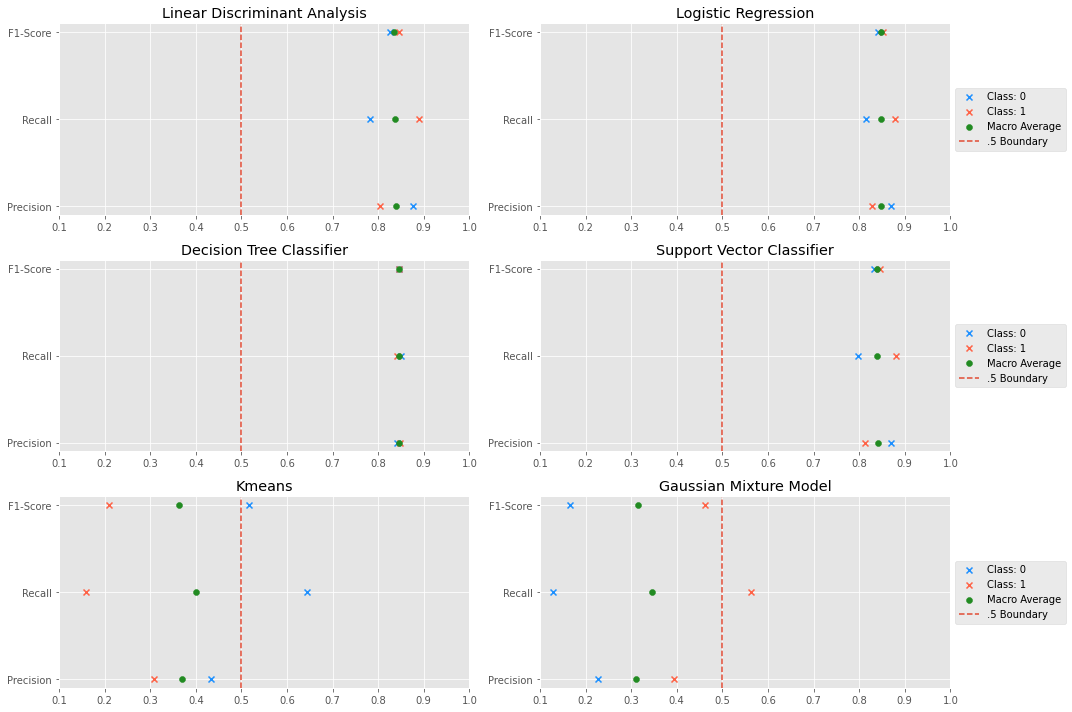

In [16]:
plt.figure(figsize = (15, 10))
for index, value in enumerate(estimators):
    plt.subplot(3, 2, index + 1)
    plt.title(value[0])
    class_pred = value[1].fit(X_train, y_train).predict(X_test)
    afx.plot_classification_report(y_test, class_pred, dummy_class=True)
    plt.xlim((0.1, 1.0))
    if (index + 1) % 2 == 0:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()


Cabe destacar que 4 de 6 clasificadores que forman parte del comité presentan un
desempeño más que aceptable. En promedio, tanto Linear Discriminant Analysis, Logistic
Regression, Decision Tree Classifier y Support Vector Machine presentan métricas sobre el
80% en Precision, Recall y F1. En el otro extremo encontramos los modelos KMeans y
Gaussian Mixture Model, que presentan un desempeño general substancialmente peor que
un clasificador aleatorio. Cabe destacar que mantendremos estos clasificadores en el
comité por motivos pedagógicos. En aplicaciones serias, estos modelos se eliminarían del
comité.

De los primeros cuatro modelos, el comportamiento de Decision Tree Classifer es mucho
más estable a nivel de clases específicas en comparación a los otros tres modelos. En
específico, se observa que tanto para Linear Discriminant Analysis, Logistic Regression y
Support Vector Classifier tienen un mejor recall en la clase 1. Esto significa que logran
capturar más registros, mientras que tienden a clasificar con una mayor precisión las clases
0.

Resulta que cada modelo responde a distintas representaciones de los datos. De esta
manera, al implementar el algoritmo de votación sklearn.ensemble.VotingClassifier
promediamos virtudes y defectos de cada clasificador individual. Por el momento,
generemos una implementación vanilla del modelo, sin modificar hiper parámetros.


In [23]:
# VotingClassifier requiere de la lista de tuplas que definimos arriba
voting_classifier = VotingClassifier(estimators)#.fit(X_train, y_train)

Si visualizamos el comportamiento del ensamble heterogéneo, éste tiende a corregir el
comportamiento de los indicadores, asimilandose entre sí. Observamos que los puntajes f1
para cada clase converge con el promedio. De igual manera, el recall de la clase 0 mejora en
comparación al desempeño de los modelos con desempeños superiores pero que tenían un
recall bajo de la clase 0.

In [24]:
afx.plot_classification_report(y_test,voting_classifier.fit(X_train,y_train).predict(X_test), dummy_class=True)
plt.xlim((0.4, 1.0))
plt.title('Voting Classifier')
plt.legend(loc='center left', bbox_to_anchor = (1, 0.5))

ValueError: The estimator KMeans should be a classifier.